In [45]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [46]:
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

test_x = torch.linspace(0, 1, 101)

In [47]:
train_y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [48]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

#test_dataset = TensorDataset(test_x, test_y)
#test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [49]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [ ]:
num_epochs = 100


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.005)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

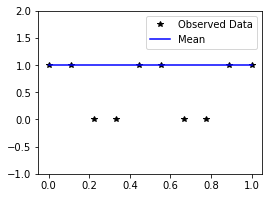

In [43]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    #test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])